# Linear Regression & Regularization in scikit‑learn


**What you'll practice**
- Build `X` and `y`
- Train/test split
- `Pipeline` with `StandardScaler`
- `LinearRegression`, `RidgeCV`, `LassoCV`
- Metrics: MSE, MAE, R²
- Interpreting coefficients and plotting predictions


In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
np.random.seed(0)


## 1) Create a tiny housing dataset (synthetic)
Features:
- `size_sqft` (500–2500)
- `bedrooms` (1–5)
- `age_yrs` (0–80)

Target:
- `price_k` (in $1000s), generated from a simple linear rule with noise


In [3]:
m = 120
size = np.random.randint(500, 2501, size=m)
bedrooms = np.random.randint(1, 6, size=m)
age = np.random.randint(0, 81, size=m)
# Ground truth weights (in thousands):
w_size, w_bed, w_age, b0 = 0.30, 20.0, -0.50, 100.0
noise = np.random.normal(0, 25, size=m)
price = b0 + w_size*size + w_bed*bedrooms + w_age*age + noise

df = pd.DataFrame({
    'size_sqft': size,
    'bedrooms': bedrooms,
    'age_yrs': age,
    'price_k': price
})
df.head()


,size_sqft,bedrooms,age_yrs,price_k
0,1184,1,23,443.607779
1,1059,2,53,417.410943
2,2153,2,51,752.089655
3,1716,4,46,717.912912
4,1335,1,20,499.930601


## 2) Visualize one relationship
We'll make a single scatter plot of `size_sqft` vs `price_k` to see the trend.


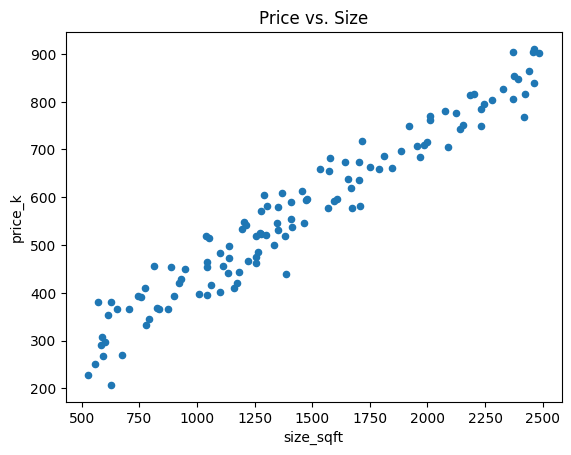

In [4]:
plt.figure()
plt.scatter(df['size_sqft'], df['price_k'], s=20)
plt.xlabel('size_sqft')
plt.ylabel('price_k')
plt.title('Price vs. Size')
plt.show()


## 3) Train/test split and a Pipeline
We'll standardize features and fit a linear model.


In [5]:
X = df[['size_sqft', 'bedrooms', 'age_yrs']].values
y = df['price_k'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

linear = Pipeline([
    ('scale', StandardScaler()),
    ('model', LinearRegression())
]).fit(X_train, y_train)

coef = linear.named_steps['model'].coef_
intercept = linear.named_steps['model'].intercept_
print('LinearRegression coefficients:', coef)
print('intercept:', intercept)


LinearRegression coefficients: [166.75580113  28.91377858 -13.13708272]
intercept: 568.9208836275731


## 4) Evaluate and plot predictions


Linear: MSE=741.60  MAE=22.09  R^2=0.976


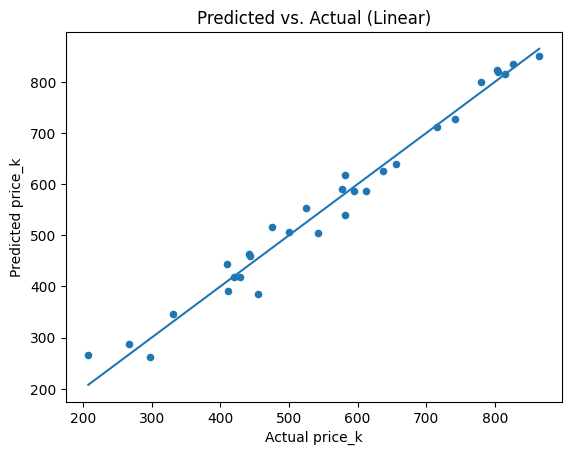

In [6]:
def evaluate(name, est):
    y_pred = est.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MSE={mse:.2f}  MAE={mae:.2f}  R^2={r2:.3f}")
    return y_pred

y_pred_linear = evaluate('Linear', linear)
plt.figure()
plt.scatter(y_test, y_pred_linear, s=20)
lims = [min(y_test.min(), y_pred_linear.min()), max(y_test.max(), y_pred_linear.max())]
plt.plot(lims, lims)
plt.xlabel('Actual price_k')
plt.ylabel('Predicted price_k')
plt.title('Predicted vs. Actual (Linear)')
plt.show()


## 5) Ridge and Lasso with cross‑validation
We'll search a range of alphas and compare.


In [7]:
alphas = np.logspace(-3, 3, 30)
ridge = Pipeline([
    ('scale', StandardScaler()),
    ('model', RidgeCV(alphas=alphas))
]).fit(X_train, y_train)
lasso = Pipeline([
    ('scale', StandardScaler()),
    ('model', LassoCV(alphas=alphas, max_iter=10000, random_state=0))
]).fit(X_train, y_train)

y_pred_ridge = evaluate('Ridge', ridge)
y_pred_lasso = evaluate('Lasso', lasso)

ridge_alpha = ridge.named_steps['model'].alpha_
lasso_alpha = lasso.named_steps['model'].alpha_
print('Chosen alphas -> Ridge:', ridge_alpha, ' Lasso:', lasso_alpha)


Ridge: MSE=741.49  MAE=22.08  R^2=0.976
Lasso: MSE=743.12  MAE=22.08  R^2=0.976
Chosen alphas -> Ridge: 0.0727895384398315  Lasso: 0.18873918221350977


## 6) Compare coefficients
With standardized features, coefficients are roughly comparable in scale.


In [8]:
features = ['size_sqft', 'bedrooms', 'age_yrs']
coef_df = pd.DataFrame({
    'feature': features,
    'Linear': linear.named_steps['model'].coef_,
    'Ridge': ridge.named_steps['model'].coef_,
    'Lasso': lasso.named_steps['model'].coef_
})
coef_df


,feature,Linear,Ridge,Lasso
0,size_sqft,166.755801,166.615575,166.527660
1,bedrooms,28.913779,28.884596,28.710425
2,age_yrs,-13.137083,-13.105728,-12.910030


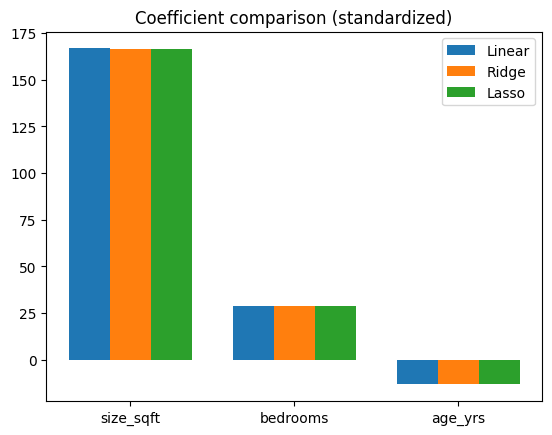

In [9]:
plt.figure()
x = np.arange(len(features))
width = 0.25
plt.bar(x - width, coef_df['Linear'], width, label='Linear')
plt.bar(x, coef_df['Ridge'], width, label='Ridge')
plt.bar(x + width, coef_df['Lasso'], width, label='Lasso')
plt.xticks(x, features)
plt.title('Coefficient comparison (standardized)')
plt.legend()
plt.show()


## 7) Predict for a new house


In [10]:
new_home = np.array([[1800, 3, 20]])
print('Linear:', linear.predict(new_home))
print('Ridge:', ridge.predict(new_home))
print('Lasso:', lasso.predict(new_home))


Linear: [687.97312267]
Ridge: [687.85713474]
Lasso: [687.63946682]
